In [1]:
import nest_asyncio
nest_asyncio.apply()

In [2]:
%load_ext tensorboard

In [3]:
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'

import collections

import numpy as np
import tensorflow as tf
import tensorflow_federated as tff

Check if everything is ok

In [4]:
np.random.seed(0)

tff.federated_computation(lambda: 'Hello, World!')()

b'Hello, World!'

## Preparing the input data

Let's start with the data. Federated learning requires a federated data set,
i.e., a collection of data from multiple users. Federated data is typically
non-[i.i.d.](https://en.wikipedia.org/wiki/Independent_and_identically_distributed_random_variables),
which poses a unique set of challenges.

In order to facilitate experimentation, we seeded the TFF repository with a few
datasets, including a federated version of MNIST that contains a version of the [original NIST dataset](https://www.nist.gov/srd/nist-special-database-19) that has been re-processed using [Leaf](https://github.com/TalwalkarLab/leaf) so that the data is keyed by the original writer of the digits. Since each writer has a unique style, this dataset exhibits the kind of non-i.i.d. behavior expected of federated datasets.

Here's how we can load it.

In [5]:
emnist_train, emnist_test = tff.simulation.datasets.emnist.load_data()

The data sets returned by `load_data()` are instances of
`tff.simulation.ClientData`, an interface that allows you to enumerate the set
of users, to construct a `tf.data.Dataset` that represents the data of a
particular user, and to query the structure of individual elements. Here's how
you can use this interface to explore the content of the data set. Keep in mind
that while this interface allows you to iterate over clients ids, this is only a
feature of the simulation data. As you will see shortly, client identities are
not used by the federated learning framework - their only purpose is to allow
you to select subsets of the data for simulations.

In [6]:
len(emnist_train.client_ids)

3383

In [7]:
emnist_train.element_type_structure

OrderedDict([('label', TensorSpec(shape=(), dtype=tf.int32, name=None)),
             ('pixels',
              TensorSpec(shape=(28, 28), dtype=tf.float32, name=None))])

In [8]:
example_dataset = emnist_train.create_tf_dataset_for_client(
    emnist_train.client_ids[0]
)

example_element = next(iter(example_dataset))

example_element['label'].numpy()

1

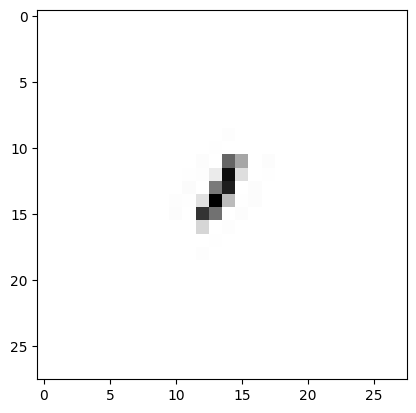

In [9]:
from matplotlib import pyplot as plt
plt.imshow(example_element['pixels'].numpy(), cmap='gray', aspect='equal')
plt.grid(False)
_ = plt.show()

### Exploring heterogeneity in federated data

Federated data is typically non-[i.i.d.](https://en.wikipedia.org/wiki/Independent_and_identically_distributed_random_variables), users typically have different distributions of data depending on usage patterns. Some clients may have fewer training examples on device, suffering from data paucity locally, while some clients will have more than enough training examples. Let's explore this concept of data heterogeneity typical of a federated system with the EMNIST data we have available. It's important to note that this deep analysis of a client's data is only available to us because this is a simulation environment where all the data is available to us locally. In a real production federated environment you would not be able to inspect a single client's data.

First, let's grab a sampling of one client's data to get a feel for the examples on one simulated device. Because the dataset we're using has been keyed by unique writer, the data of one client represents the handwriting of one person for a sample of the digits 0 through 9, simulating the unique "usage pattern" of one user.

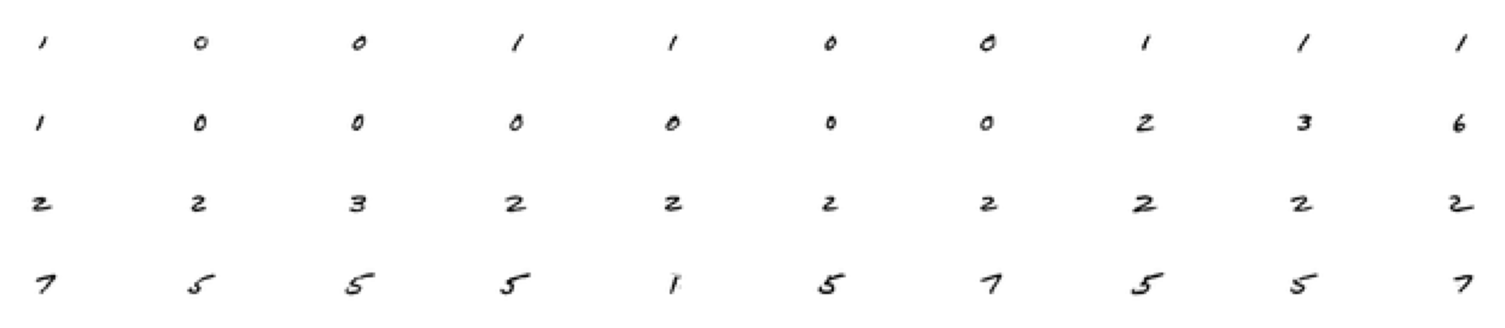

In [10]:
## Example MNIST digits for one client
figure = plt.figure(figsize=(20, 4))
j = 0

for example in example_dataset.take(40):
    plt.subplot(4, 10, j+1)
    plt.imshow(example['pixels'].numpy(), cmap='gray', aspect='equal')
    plt.axis('off')
    j += 1

Now let's visualize the number of examples on each client for each MNIST digit label. In the federated environment, the number of examples on each client can vary quite a bit, depending on user behavior.

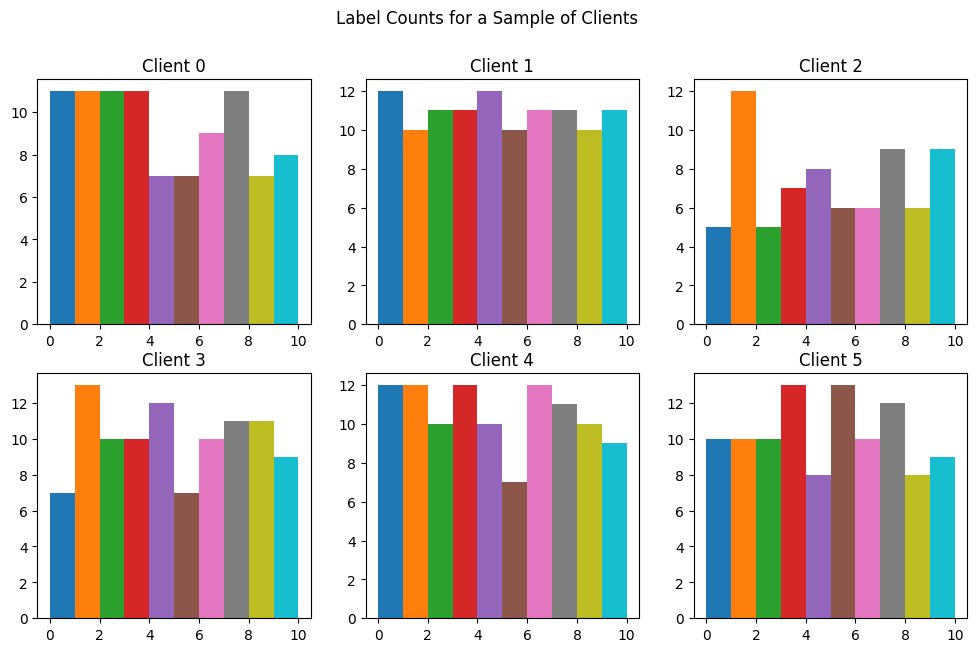

In [11]:
# Number of examples per layer for a sample of clients
f = plt.figure(figsize=(12, 7))
f.suptitle('Label Counts for a Sample of Clients')
for i in range(6):
    client_dataset = emnist_train.create_tf_dataset_for_client(
        emnist_train.client_ids[i])
    plot_data = collections.defaultdict(list)
    for example in client_dataset:
        # Append counts individually per label to make plots
        # more colorful instead of one color per plot.
        label = example['label'].numpy()
        plot_data[label].append(label)
    plt.subplot(2, 3, i+1)
    plt.title('Client {}'.format(i))
    for j in range(10):
        plt.hist(
            plot_data[j],
            density=False,
            bins=[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10])

Now let's visualize the mean image per client for each MNIST label. This code will produce the mean of each pixel value for all of the user's examples for one label. We'll see that one client's mean image for a digit will look different than another client's mean image for the same digit, due to each person's unique handwriting style. We can muse about how each local training round will nudge the model in a different direction on each client, as we're learning from that user's own unique data in that local round. Later in the tutorial we'll see how we can take each update to the model from all the clients and aggregate them together into our new global model, that has learned from each of our client's own unique data.

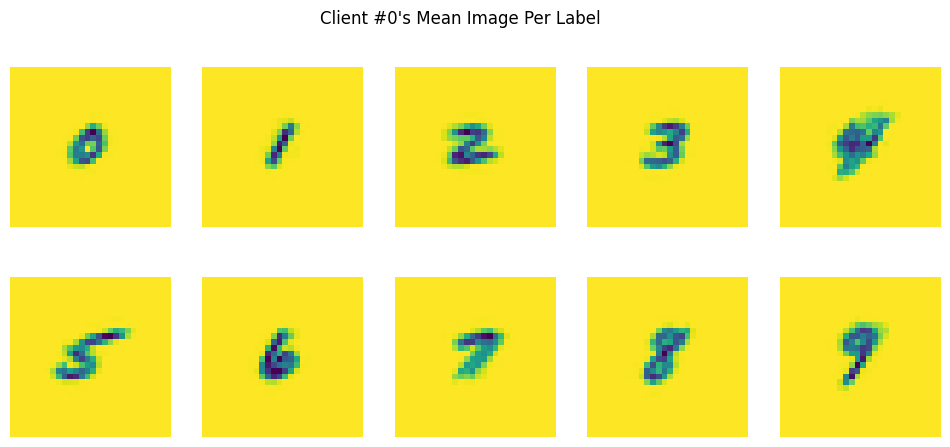

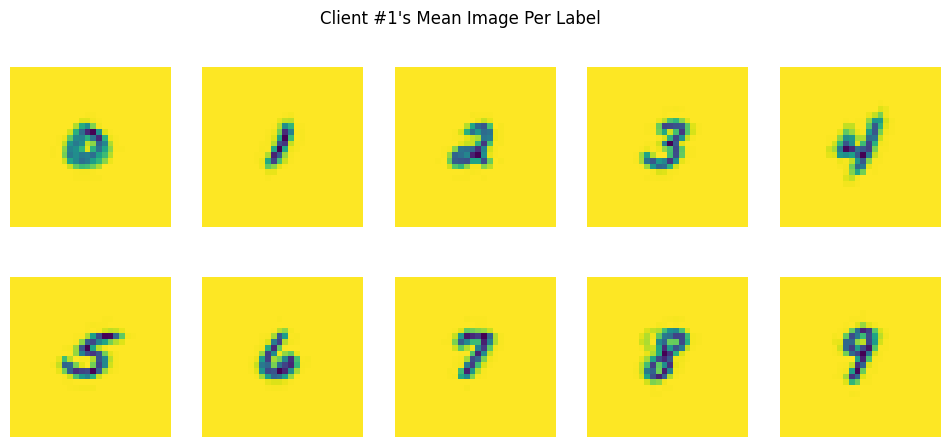

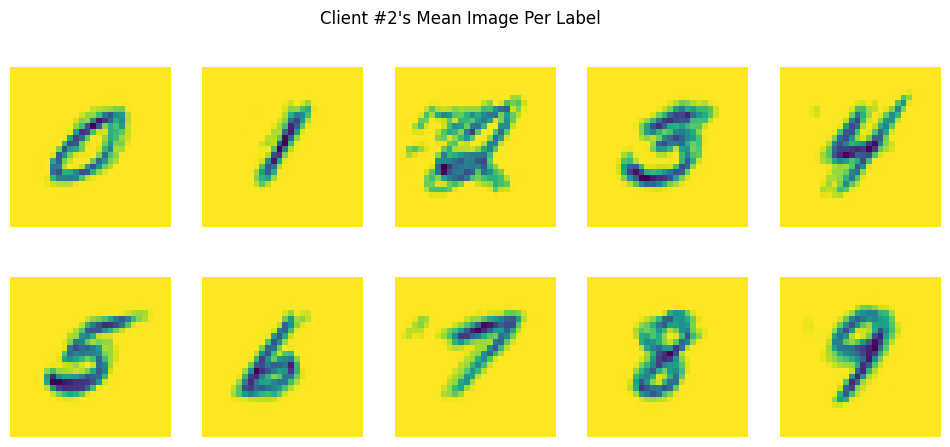

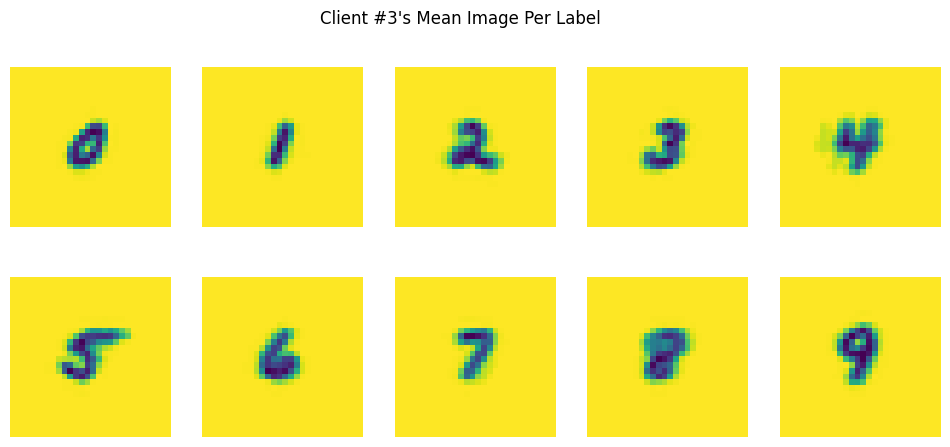

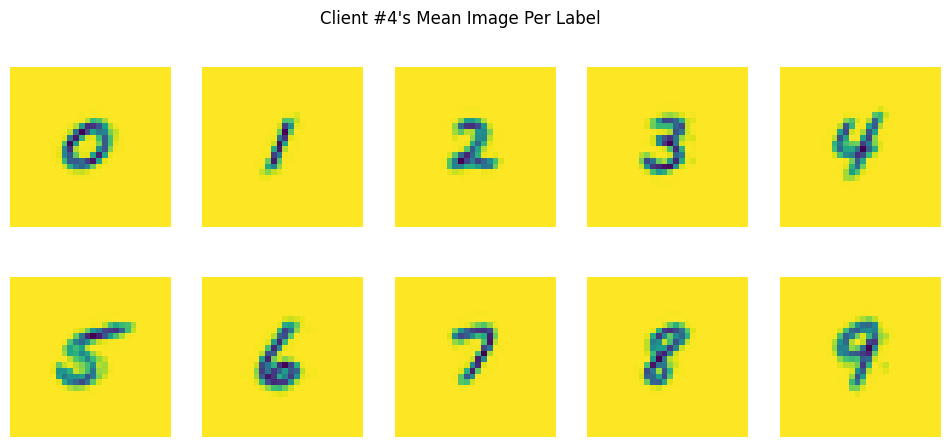

In [12]:
# Each client has different mean images, meaning each client will be nudging
# the model in their own directions locally.

for i in range(5):
    client_dataset = emnist_train.create_tf_dataset_for_client(
        emnist_train.client_ids[i])
    plot_data = collections.defaultdict(list)
    for example in client_dataset:
        plot_data[example['label'].numpy()].append(example['pixels'].numpy())
    f = plt.figure(i, figsize=(12, 5))
    f.suptitle("Client #{}'s Mean Image Per Label".format(i))
    for j in range(10):
        mean_img = np.mean(plot_data[j], 0)
        plt.subplot(2, 5, j+1)
        plt.imshow(mean_img.reshape((28, 28)))
        plt.axis('off')

User data can be noisy and unreliably labeled. For example, looking at Client #2's data above, we can see that for label 2, it is possible that there may have been some mislabeled examples creating a noisier mean image.

### Preprocessing the input data

Since the data is already a `tf.data.Dataset`,  preprocessing can be accomplished using Dataset transformations. Here, we flatten the `28x28` images
into `784`-element arrays, shuffle the individual examples, organize them into batches, and rename the features
from `pixels` and `label` to `x` and `y` for use with Keras. We also throw in a
`repeat` over the data set to run several epochs.

In [13]:
NUM_CLIENTS = 10
NUM_EPOCHS = 5
BATCH_SIZE = 20
SHUFFLE_BUFFER = 100
PREFETCH_BUFFER = 10

def preprocess(dataset):

    def batch_format_fn(element):
        """Flatten a batch `pixels` and return the features as an `OrderedDict`."""
        return collections.OrderedDict(
            x=tf.reshape(element['pixels'], [-1, 784]),
            y=tf.reshape(element['label'], [-1, 1])
        )

    return dataset.repeat(NUM_EPOCHS).shuffle(SHUFFLE_BUFFER, seed=1) \
        .batch(BATCH_SIZE).map(batch_format_fn) \
        .prefetch(PREFETCH_BUFFER)

Let's verify this worked.

In [14]:
preprocessed_example_dataset = preprocess(example_dataset)

sample_batch = tf.nest.map_structure(
    lambda x: x.numpy(),
    next(iter(preprocessed_example_dataset))
)

sample_batch

OrderedDict([('x',
              array([[1., 1., 1., ..., 1., 1., 1.],
                     [1., 1., 1., ..., 1., 1., 1.],
                     [1., 1., 1., ..., 1., 1., 1.],
                     ...,
                     [1., 1., 1., ..., 1., 1., 1.],
                     [1., 1., 1., ..., 1., 1., 1.],
                     [1., 1., 1., ..., 1., 1., 1.]], dtype=float32)),
             ('y',
              array([[2],
                     [1],
                     [5],
                     [7],
                     [1],
                     [7],
                     [7],
                     [1],
                     [4],
                     [7],
                     [4],
                     [2],
                     [2],
                     [5],
                     [4],
                     [1],
                     [1],
                     [0],
                     [0],
                     [9]], dtype=int32))])

We have almost all the building blocks in place to construct federated data
sets.

One of the ways to feed federated data to TFF in a simulation is simply as a
Python list, with each element of the list holding the data of an individual
user, whether as a list or as a `tf.data.Dataset`. Since we already have
an interface that provides the latter, let's use it.

Here's a simple helper function that will construct a list of datasets from the
given set of users as an input to a round of training or evaluation.

In [15]:
def make_federated_data(client_data, client_ids):
    return [
        preprocess(client_data.create_tf_dataset_for_client(x))
        for x in client_ids
    ]

Now, how do we choose clients?

In a typical federated training scenario, we are dealing with potentially a very
large population of user devices, only a fraction of which may be available for
training at a given point in time. This is the case, for example, when the
client devices are mobile phones that participate in training only when plugged
into a power source, off a metered network, and otherwise idle.

Of course, we are in a simulation environment, and all the data is locally
available. Typically then, when running simulations, we would simply sample a
random subset of the clients to be involved in each round of training, generally
different in each round.

That said, as you can find out by studying the paper on the
[Federated Averaging](https://arxiv.org/abs/1602.05629) algorithm, achieving convergence in a system with randomly sampled
subsets of clients in each round can take a while, and it would be impractical
to have to run hundreds of rounds in this interactive tutorial.

What we'll do instead is sample the set of clients once, and
reuse the same set across rounds to speed up convergence (intentionally
over-fitting to these few user's data). We leave it as an exercise for the
reader to modify this tutorial to simulate random sampling - it is fairly easy to
do (once you do, keep in mind that getting the model to converge may take a
while).

In [16]:
sample_clients = emnist_train.client_ids[0:NUM_CLIENTS]

federated_train_data = make_federated_data(emnist_train, sample_clients)

print(f'Number of client datasets: {len(federated_train_data)}')
print(f'First dataset: {federated_train_data[0]}')

Number of client datasets: 10
First dataset: <PrefetchDataset element_spec=OrderedDict([('x', TensorSpec(shape=(None, 784), dtype=tf.float32, name=None)), ('y', TensorSpec(shape=(None, 1), dtype=tf.int32, name=None))])>


## Creating a model with Keras

If you are using Keras, you likely already have code that constructs a Keras
model. Here's an example of a simple model that will suffice for our needs.

In [17]:
def create_keras_model():
    return tf.keras.models.Sequential([
        tf.keras.layers.InputLayer(input_shape=(784,)),
        tf.keras.layers.Dense(10, kernel_initializer='zeros'),
        tf.keras.layers.Softmax(),
    ])

**Note:** we do not compile the model yet. The loss, metrics, and optimizers are introduced later.

In order to use any model with TFF, it needs to be wrapped in an instance of the
`tff.learning.Model` interface, which exposes methods to stamp the model's
forward pass, metadata properties, etc., similarly to Keras, but also introduces
additional elements, such as ways to control the process of computing federated
metrics. Let's not worry about this for now; if you have a Keras model like the
one we've just defined above, you can have TFF wrap it for you by invoking
`tff.learning.from_keras_model`, passing the model and a sample data batch as
arguments, as shown below.

In [18]:
def model_fn():
    # We _must_ create a new model here, and _not_ capture it from an external
    # scope. TFF will call this within different graph contexts.
    keras_model = create_keras_model()
    return tff.learning.from_keras_model(
        keras_model,
        input_spec=preprocessed_example_dataset.element_spec,
        loss=tf.keras.losses.SparseCategoricalCrossentropy(),
        metrics=[tf.keras.metrics.SparseCategoricalAccuracy()]
    )

## Training the model on federated data

Now that we have a model wrapped as `tff.learning.Model` for use with TFF, we
can let TFF construct a Federated Averaging algorithm by invoking the helper
function `tff.learning.algorithms.build_weighted_fed_avg`, as follows.

Keep in mind that the argument needs to be a constructor (such as `model_fn`
above), not an already-constructed instance, so that the construction of your
model can happen in a context controlled by TFF (if you're curious about the
reasons for this, we encourage you to read the follow-up tutorial on
[custom algorithms](custom_federated_algorithms_1.ipynb)).

One critical note on the Federated Averaging algorithm below, there are **2**
optimizers: a _client_optimizer_ and a _server_optimizer_. The
_client_optimizer_ is only used to compute local model updates on each client.
The _server_optimizer_ applies the averaged update to the global model at the
server. In particular, this means that the choice of optimizer and learning rate
used may need to be different than the ones you have used to train the model on
a standard i.i.d. dataset. We recommend starting with regular SGD, possibly with
a smaller learning rate than usual. The learning rate we use has not been
carefully tuned, feel free to experiment.

In [24]:
training_process = tff.learning.algorithms.build_weighted_fed_avg(
    model_fn,
    client_optimizer_fn=lambda: tf.keras.optimizers.SGD(learning_rate=0.02),
    server_optimizer_fn=lambda: tf.keras.optimizers.SGD(learning_rate=1.0)
)

What just happened? TFF has constructed a pair of *federated computations* and
packaged them into a `tff.templates.IterativeProcess` in which these computations
are available as a pair of properties `initialize` and `next`.

In a nutshell, *federated computations* are programs in TFF's internal language
that can express various federated algorithms (you can find more about this in
the [custom algorithms](custom_federated_algorithms_1.ipynb) tutorial). In this
case, the two computations generated and packed into `iterative_process`
implement [Federated Averaging](https://arxiv.org/abs/1602.05629).

It is a goal of TFF to define computations in a way that they could be executed
in real federated learning settings, but currently only local execution
simulation runtime is implemented. To execute a computation in a simulator, you
simply invoke it like a Python function. This default interpreted environment is
not designed for high performance, but it will suffice for this tutorial; we
expect to provide higher-performance simulation runtimes to facilitate
larger-scale research in future releases.

Let's start with the `initialize` computation. As is the case for all federated
computations, you can think of it as a function. The computation takes no
arguments, and returns one result - the representation of the state of the
Federated Averaging process on the server. While we don't want to dive into the
details of TFF, it may be instructive to see what this state looks like. You can
visualize it as follows.

In [20]:
print(training_process.initialize.type_signature.formatted_representation())

( -> <
  global_model_weights=<
    trainable=<
      float32[784,10],
      float32[10]
    >,
    non_trainable=<>
  >,
  distributor=<>,
  client_work=<>,
  aggregator=<
    value_sum_process=<>,
    weight_sum_process=<>
  >,
  finalizer=<
    int64,
    float32[784,10],
    float32[10]
  >
>@SERVER)


While the above type signature may at first seem a bit cryptic, you can
recognize that the server state consists of a `global_model_weights` (the initial model parameters for MNIST that will be distributed to all devices), some empty parameters (like `distributor`, which governs the server-to-client communication) and a `finalizer` component. This last one governs the logic that the server uses to update its model at the end of a round, and contains an integer representing how many rounds of FedAvg have occurred.

Let's invoke the `initialize` computation to construct the server state.

In [21]:
train_state = training_process.initialize()

The second of the pair of federated computations, `next`, represents a single
round of Federated Averaging, which consists of pushing the server state
(including the model parameters) to the clients, on-device training on their
local data, collecting and averaging model updates, and producing a new updated
model at the server.

**In particular, one should think about** `next()` **not as being a function that runs on a server, but rather being a declarative functional representation of the entire decentralized computation - some of the inputs are provided by the server** (`SERVER_STATE`), **but each participating device contributes its own local dataset.**

Let's run a single round of training and visualize the results. We can use the
federated data we've already generated above for a sample of users.


In [22]:
result = training_process.next(train_state, federated_train_data)
train_state = result.state
train_metrics = result.metrics
print('round  1, metrics={}'.format(train_metrics))

round  1, metrics=OrderedDict([('distributor', ()), ('client_work', OrderedDict([('train', OrderedDict([('sparse_categorical_accuracy', 0.12345679), ('loss', 3.119374), ('num_examples', 4860), ('num_batches', 248)]))])), ('aggregator', OrderedDict([('mean_value', ()), ('mean_weight', ())])), ('finalizer', OrderedDict([('update_non_finite', 0)]))])


Let's run a few more rounds. As noted earlier, typically at this point you would
pick a subset of your simulation data from a new randomly selected sample of
users for each round in order to simulate a realistic deployment in which users
continuously come and go, but in this interactive notebook, for the sake of
demonstration we'll just reuse the same users, so that the system converges
quickly.

In [23]:
NUM_ROUNDS = 11
for round_num in range(2, NUM_ROUNDS):
    result = training_process.next(train_state, federated_train_data)
    train_state = result.state
    train_metrics = result.metrics
    print('round {:2d}, metrics={}'.format(round_num, train_metrics))
    print()

round  2, metrics=OrderedDict([('distributor', ()), ('client_work', OrderedDict([('train', OrderedDict([('sparse_categorical_accuracy', 0.14012346), ('loss', 2.9851403), ('num_examples', 4860), ('num_batches', 248)]))])), ('aggregator', OrderedDict([('mean_value', ()), ('mean_weight', ())])), ('finalizer', OrderedDict([('update_non_finite', 0)]))])

round  3, metrics=OrderedDict([('distributor', ()), ('client_work', OrderedDict([('train', OrderedDict([('sparse_categorical_accuracy', 0.1590535), ('loss', 2.861713), ('num_examples', 4860), ('num_batches', 248)]))])), ('aggregator', OrderedDict([('mean_value', ()), ('mean_weight', ())])), ('finalizer', OrderedDict([('update_non_finite', 0)]))])

round  4, metrics=OrderedDict([('distributor', ()), ('client_work', OrderedDict([('train', OrderedDict([('sparse_categorical_accuracy', 0.17860082), ('loss', 2.740137), ('num_examples', 4860), ('num_batches', 248)]))])), ('aggregator', OrderedDict([('mean_value', ()), ('mean_weight', ())])), ('fin